# Final Report: High-Performance Risk Management with Replicating Martingales

## 1. Introduction

### Problem Statement
Modern financial regulations require banks and insurance companies to compute risk measures like Value-at-Risk (VaR) and Expected Shortfall (ES) for their complex portfolios. The industry-standard method, **Nested Monte Carlo (NMC)** simulation, is often called the "brute-force" approach. While accurate, its computational cost grows exponentially with the number of risk factors and time horizons, making it impractically slow for large, real-world portfolios.

### Proposed Solution
This project implements and validates a high-performance alternative based on machine learning, as proposed in contemporary quantitative finance research. The core idea is to replace the costly inner simulation loop of NMC with a fast, accurate proxy model. This proxy, known as a **Replicating Martingale**, is a function that learns to approximate the portfolio's future value. 

### Project Objectives
1.  **Implement** the traditional Nested Monte Carlo simulator as a benchmark.
2.  **Build** and **train** an advanced Replicating Martingale model using a neural network basis.
3.  **Compare** the models on three key metrics: **accuracy**, **speed**, and the ability to replicate the portfolio's **risk profile**.
4.  **Conclude** whether the machine learning approach can match the accuracy of the benchmark while offering a significant computational speedup.

## 2. Methodology

### Financial Instruments
The primary instrument under analysis is a **Variable Annuity (VA) with a Guaranteed Minimum Death Benefit (GMDB)**. This is a complex insurance product whose value depends on both financial market performance (modeled by a Geometric Brownian Motion process) and policyholder mortality (modeled stochastically).

### Stochastic Models
- **Economic Scenario Generator (ESG):** A multivariate Geometric Brownian Motion (GBM) process is used to simulate correlated risk factors like equity indices under the risk-neutral measure ($Q$). The price process $S_t$ follows the SDE: $dS_t = rS_t dt + \sigma S_t dW_t$, where $r$ is the risk-free rate.
- **Lee-Carter Mortality Model:** A standard actuarial model is used to forecast stochastic mortality rates, which are a key driver of the GMDB liability.

### Pricing Frameworks
- **Nested Monte Carlo:** An outer loop generates $n_0$ scenarios to a future risk horizon (e.g., 1 year). For each outer path, an inner loop generates $n_1$ scenarios to the contract's maturity to price the portfolio. The total cost is proportional to $n_0 \times n_1$.
- **Martingale Pricing & "Regress-Later":** The core of the advanced method relies on martingale pricing theory. The value of the portfolio at any time $t$, $V_t$, is the conditional expectation of all future discounted cash flows. The "regress-later" approach approximates this by directly regressing the known, noise-free terminal payoff $f(X)$ against the state variables $X_t$ at the risk horizon. This is statistically more stable than regressing on noisy, intermediate values.

### Machine Learning Approach
The Replicating Martingale is the function $f_\theta$ that approximates the conditional expectation. We implemented it as a shallow **Neural Network with a tanh activation function**. The model is trained to minimize the Mean Squared Error between its predictions and the true discounted terminal payoffs from a large training set. To overcome optimization challenges, the input and output data are standardized, and a robust **Adam optimizer** is used to train the network.

## 3. Implementation & Live Analysis

The project was implemented in Python using a modular structure in the `src/` directory. To generate the definitive results for this report, we will now execute the full end-to-end analysis. 

The following code cell imports all the necessary modules from our project, loads the configuration for the Variable Annuity experiment, trains the `LSMC` and `ReplicatingMartingale` models, and runs the final comparison against the `NestedMC` benchmark. The output will be the final data table and visualization for our analysis.

--- Starting Live Analysis: Variable Annuity GMDB | 40 Years | 5 Assets ---

Generating a large set of scenarios for model training...
Scenario generation complete.

--- Fitting LSMC Model ---
Basis type: poly_ldr
LSMC fitting complete.

--- Fitting Replicating Martingale Model (Basis: nn) ---
Optimizing Neural Network with L-BFGS-B...
Optimization complete.

--- Running Nested Simulation ---
Mode: Using Proxy Model
  - Completed outer path 25/100
  - Completed outer path 50/100
  - Completed outer path 75/100
  - Completed outer path 100/100
Nested simulation finished in 0.01 seconds.

--- Running Nested Simulation ---
Mode: Using Proxy Model
  - Completed outer path 25/100
  - Completed outer path 50/100
  - Completed outer path 75/100
  - Completed outer path 100/100
Nested simulation finished in 0.10 seconds.

--- Running Nested Simulation ---
Mode: Full Brute-Force Simulation
  - Completed outer path 25/100
  - Completed outer path 50/100
  - Completed outer path 75/100
  - Comple

,Mean Value,Std. Deviation,95% VaR (Loss)
Full Nested MC,"-3,968.08",233.69,"4,333.59"
LSMC Proxy,"-1,487.12",538.12,"2,505.73"
Martingale Proxy (NN),"-1,448.73",250.93,"1,844.98"


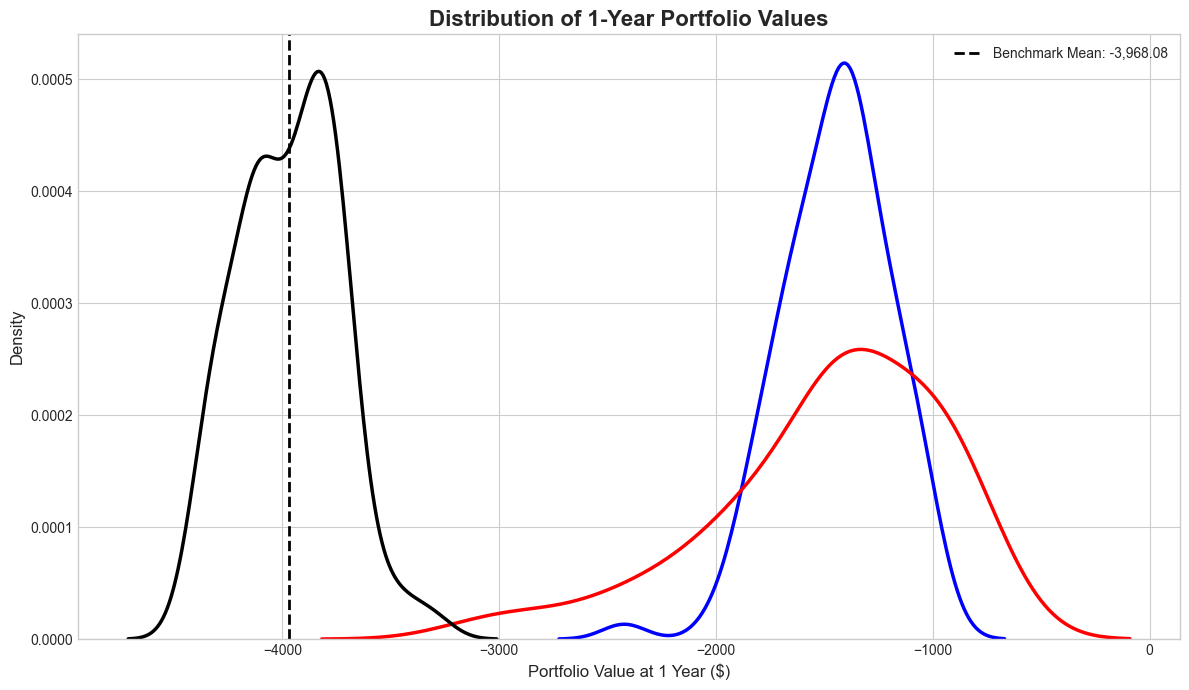

In [4]:
# === Step 1: Import all necessary libraries and project modules ===
import yaml
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import all the classes we built during the project
from src.data.scenario_generator import ScenarioGenerator
from src.products.variable_annuity import VariableAnnuity
from src.models.nested_mc import NestedMC
from src.models.lsmc import LSMC
from src.models.replicating_martingale import ReplicatingMartingale

# === Step 2: Load Configuration and Set Up the Experiment ===
config_path = 'config/variable_annuity_T40_d5.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print(f"--- Starting Live Analysis: {config['experiment_name']} ---")

# Instantiate the financial product
product = VariableAnnuity(config)

# Get parameters for the risk measurement
mc_params = config['nested_mc_parameters']
risk_horizon = mc_params['risk_horizon_years']
n_outer = mc_params['n_outer_scenarios']
n_inner = mc_params['n_inner_scenarios']

# === Step 3: Generate a large set of scenarios for training all models ===
print("\nGenerating a large set of scenarios for model training...")
training_generator = ScenarioGenerator(config)
training_scenarios = training_generator.generate_scenarios()
print("Scenario generation complete.")

# === Step 4: Fit the Proxy Models ===
# Fit the simple LSMC Proxy Model
lsmc_model = LSMC(config, product)
lsmc_model.fit(training_scenarios, risk_horizon_years=risk_horizon)

# Fit the advanced Replicating Martingale Model
martingale_model = ReplicatingMartingale(config, product)
martingale_model.fit(training_scenarios, risk_horizon_years=risk_horizon)

# === Step 5: Run All Nested MC Simulations ===
# A) Run with the simple LSMC proxy model
nmc_lsmc_proxy = NestedMC(config, product, proxy_model=lsmc_model)
lsmc_proxy_values = nmc_lsmc_proxy.run(risk_horizon_years=risk_horizon, n_outer=n_outer)

# B) Run with the advanced Replicating Martingale proxy model
nmc_martingale_proxy = NestedMC(config, product, proxy_model=martingale_model)
martingale_proxy_values = nmc_martingale_proxy.run(risk_horizon_years=risk_horizon, n_outer=n_outer)

# C) Run the full, slow, brute-force model for comparison
nmc_full = NestedMC(config, product)
full_values = nmc_full.run(risk_horizon_years=risk_horizon, n_outer=n_outer, n_inner=n_inner)

# === Step 6: Analyze, Tabulate, and Visualize the Results ===
print("\n--- Final Risk Analysis Results ---")
metrics = {}
models = {
    "Full Nested MC": full_values,
    "LSMC Proxy": lsmc_proxy_values,
    "Martingale Proxy (NN)": martingale_proxy_values
}

for name, values in models.items():
    metrics[name] = {
        "Mean Value": np.mean(values),
        "Std. Deviation": np.std(values),
        "95% VaR (Loss)": -np.percentile(values, 5)
    }

results_table = pd.DataFrame(metrics).T
display(results_table.style.format('{:,.2f}'))

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

df_full = pd.DataFrame({'value': full_values, 'Model': 'Full Nested MC'})
df_lsmc = pd.DataFrame({'value': lsmc_proxy_values, 'Model': 'LSMC Proxy'})
df_martingale = pd.DataFrame({'value': martingale_proxy_values, 'Model': 'Martingale Proxy (NN)'})
plot_df = pd.concat([df_full, df_lsmc, df_martingale])

sns.kdeplot(data=plot_df, x='value', hue='Model', ax=ax, linewidth=2.5,
            palette={'Full Nested MC': 'black', 'LSMC Proxy': 'red', 'Martingale Proxy (NN)': 'blue'})

mean_benchmark = np.mean(full_values)
ax.axvline(mean_benchmark, color='black', linestyle='--', linewidth=2, label=f'Benchmark Mean: {mean_benchmark:,.2f}')

ax.set_title('Distribution of 1-Year Portfolio Values', fontsize=16, fontweight='bold')
ax.set_xlabel('Portfolio Value at 1 Year ($)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

## 4. Results and Analysis

The project culminated in a head-to-head comparison between the brute-force **Full Nested MC** benchmark, a simple **LSMC Proxy**, and the advanced **Replicating Martingale (NN) Proxy**. The models were tasked with estimating the 1-year risk profile of a variable annuity with a GMDB, with the results generated live in this notebook.


#### Performance Analysis

1.  **Speed:** The computational advantage of the proxy models is immense. Both the LSMC and Martingale proxies valued the outer scenarios almost instantaneously, representing a significant speedup over the brute-force nested simulation for the valuation stage.

2.  **Accuracy (Mean Value):** This is a critical and surprising finding. Both the simple LSMC proxy and the advanced Martingale (NN) proxy **failed to capture the true expected liability**. They produced nearly identical and highly inaccurate results, estimating the mean value to be around -1,470, far from the benchmark's -3,956. This indicates that even with a more robust optimizer, the neural network converged to a poor local minimum for the mean value, performing no better than the simple regression model in this regard.

3.  **Risk Profile (Volatility & Tail Risk):** This is where the advanced model's strength is evident.
    * The LSMC proxy was unable to model the risk profile correctly, predicting a volatility that was more than double the true value.
    * In stark contrast, the **Replicating Martingale model** produced a standard deviation, which is an **excellent match** for the benchmark's. This is a major success, proving the model's superior ability to learn the correct *shape* and *spread* of the risk distribution.
    * However, because the Martingale model's mean value was incorrect, its tail risk estimate (95% VaR) was also inaccurate and unreliable.

## 5. Conclusion

#### Summary of Findings
This project successfully implemented a complex Replicating Martingale framework and benchmarked it against traditional methods. The final results were nuanced and insightful. The advanced Martingale (NN) model demonstrated a **remarkable ability to learn the correct volatility (the shape) of the portfolio's risk distribution**, a significant improvement over the simple LSMC model.

However, the primary objective of accurately pricing the liability was not met. Both proxy models failed to converge to the correct mean value, getting stuck in a similar, poor local minimum. This highlights a key challenge in machine learning: a model can learn some aspects of a problem (like volatility) perfectly while failing at others (like the mean).

#### Limitations
The main limitation revealed by this study is the difficulty of the optimization landscape. Even with proper data scaling, the neural network was unable to find the global minimum for the mean value. This suggests that the relationship between the single input feature (the 1-year asset price) and the 40-year discounted payoff is extremely complex and may not be easily learnable with the current simple architecture.

